# MLIP and Espresso
In this tutorial, you'll learn how to train and deploy a machine-learned interatomic potential (MLIP) with espresso.
We'll be using the [apax](https://github.com/apaxhub/apax) MLIP. (https://pubs.acs.org/doi/full/10.1021/acs.jcim.5c01221)

In 2nd part of tutorial, all physical parameters constituting the system follow those used in the system constructed in 1st part of tutorial.

In [1]:
from ase.io import read
import zntrack

box = read('water.json')

The model used in the tutorial define here to suite your task requirements. \# Exercise?

In [2]:
model = zntrack.from_rev("r_max_6_Apax")
calc = model.get_calculator()

/tikhome/hkobayashi/.env/tutotial_2025_mlip/lib/python3.12/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(


In [3]:
box.calc = calc

## MD simulations with MLIP by ESPResSo
In 2nd part of tutorial, you will combine ESPResSo with MLIP to carry out MD simulation using MLIP.

In [4]:
# ESPResSo imports
import espressomd
from espressomd.plugins.ase import ASEInterface
from espressomd.zn import Visualizer

# Miscellaneous
import pint
import tqdm

### Unit
In the majority of studies employing machine-learned interatomic potentials, energies are expressed in electronvolts (eV), distances in angstroms, and masses in atomic units. This convention does not arise from limitations of the models, but rather reflects the de facto standard that has emerged. Although machine-learning algorithms are agnostic to the choice of units, they must be trained within a consistent unit system; thus, it is essential to identify the units being used. Temporal scales are commonly expressed in femtoseconds. Consistent with this practice, ASE adopts the same unit system as its default. In the present tutorial, we employ pint to manage units.

In [5]:
ureg = pint.UnitRegistry()

### Setup System for ESPResO
All parameters, i.e, system size, the number of particles, the particle positions, are followed to `box` from ASE.

In [6]:
system = espressomd.System(box_l=box.get_cell().diagonal())
system.periodicity = [True, True, True]
system.time_step = (0.5 * ureg.fs).m_as(((1 * ureg.u * ureg.angstrom**2) / ureg.electron_volt) ** 0.5)
system.cell_system.skin = 0.4
system.part.clear()
for atom in box:
    system.part.add(pos=atom.position, type=atom.number, mass=atom.mass)

To combine ESPResSo and MLIP provided by ASE, we use `espressomd.plugins.ase.ASEInterface`.
#Exercise?

In [7]:
ase_interface = espressomd.plugins.ase.ASEInterface(
    system=system,
    type_mapping={x: x for x in set(box.numbers)},
    particle_slice=system.part.all()
    #export_charges=True
)

### Steepest Descent
We use teepset descent to mimize the energy of the system created in 1st part of tutorial.

In [8]:
system.integrator.set_steepest_descent(f_max=(0.1 * ureg.eV / ureg.angstrom).magnitude,
                                       gamma=4,
                                       max_displacement=(0.001 * ureg.angstrom).magnitude)

\#Exercise?

MD integration is carryied out by `ase_interface.integrate`.

In [9]:
tbar = tqdm.trange(500, ncols=120)
for _ in tbar:
    ase_interface.integrate(1, box.calc)
    tbar.set_description(f"E_pot: {ase_interface.atoms.get_potential_energy():.3f} eV")

E_pot: -46932.296 eV: 100%|███████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 39.60it/s]


### Equilibration
We use simplectic Euler with Langevin thermostat to equilibrate a bulk structure.

In [10]:
#Symplectic Euler with Langevin Thermostat
system.integrator.set_symplectic_euler()
system.thermostat.set_langevin(kT=(298.15 * ureg.K * ureg.boltzmann_constant).m_as("eV"), gamma=2, seed=42)

In [11]:
tbar = tqdm.trange(15000, ncols=120)
for idx in tbar:
    #atoms = system.ase.get()
    #atoms.calc = calc
    #system.part.all().ext_force = atoms.get_forces()
    #system.integrator.run(1)
    ase_interface.integrate(1, box.calc)
    tbar.set_description(f"E_pot: {ase_interface.atoms.get_potential_energy():.3f} eV")

E_pot: -46936.582 eV: 100%|███████████████████████████████████████████████████████| 15000/15000 [04:16<00:00, 58.44it/s]


### Sampling of radial distribution function (RDF)
Here, we will accumrate the radial distribution function (rdf) of oxygen-oxgen and plot them.

In [12]:
# Sampling of RDF
import numpy as np
import espressomd.observables

rdfs = []
rdf_bins = 700
r_min = 0.0
r_max = 7  # angstrom
o_ids = system.part.select(type=8).id
rdf_obs = espressomd.observables.RDF(
    ids1=o_ids, ids2=o_ids, n_r_bins=500, min_r=r_min, max_r=r_max)

tbar = tqdm.trange(2000, ncols=120)
for idx in tbar:
    ase_interface.integrate(1, box.calc)
    if idx % 5:
        rdfs.append(rdf_obs.calculate())
rdf = np.mean(rdfs, axis=0)
rdf_err = np.std(rdfs, axis=0)/np.sqrt(len(rdfs))
bin_centers = rdf_obs.bin_centers()

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 60.66it/s]


### Plot RDF
Since Van der waals radius of oxygen is 1.5 angstrom, the first peak of rdf should be arund 3.

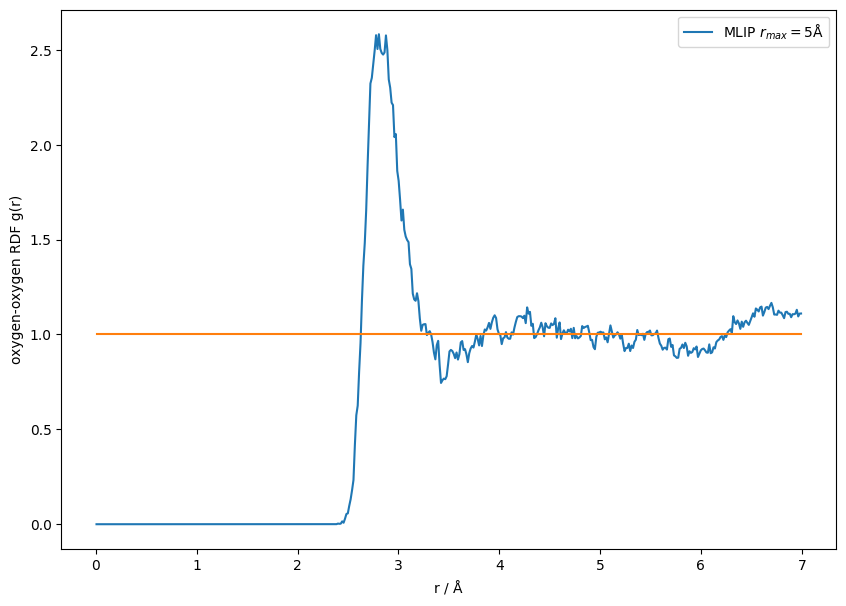

In [13]:
# Plot RDF
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(bin_centers, rdf, label=r'MLIP $r_{max}= 5\mathrm{\AA}$')
ax.plot(bin_centers, np.ones(bin_centers.size))
plt.legend()
plt.xlabel(r'r / $\mathrm{\AA}$')
plt.ylabel('oxygen-oxygen RDF g(r)')
plt.show()

Exercise

Comparison between RDF obtainded from atomistic simulations and that obtained using MLIP.